In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
df = web.DataReader('NFLX', data_source='yahoo',start='2012-01-01', end='2022-03-07')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,10.388571,10.018571,10.040000,10.320000,29213800.0,10.320000
2012-01-04,11.567143,10.258571,10.335714,11.492857,100489900.0,11.492857
2012-01-05,11.694286,11.040000,11.345714,11.328571,86552900.0,11.328571
2012-01-06,12.471429,11.242857,11.302857,12.327143,125610800.0,12.327143
2012-01-09,14.235714,12.448571,12.801429,14.025714,214073300.0,14.025714
...,...,...,...,...,...,...
2022-03-01,395.000000,383.709991,391.600006,386.239990,3290400.0,386.239990
2022-03-02,389.220001,375.209991,388.929993,380.029999,5356800.0,380.029999
2022-03-03,386.119995,364.649994,386.000000,368.070007,6076800.0,368.070007


In [19]:
data = df.filter(['Close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.81)
training_data_len

2075

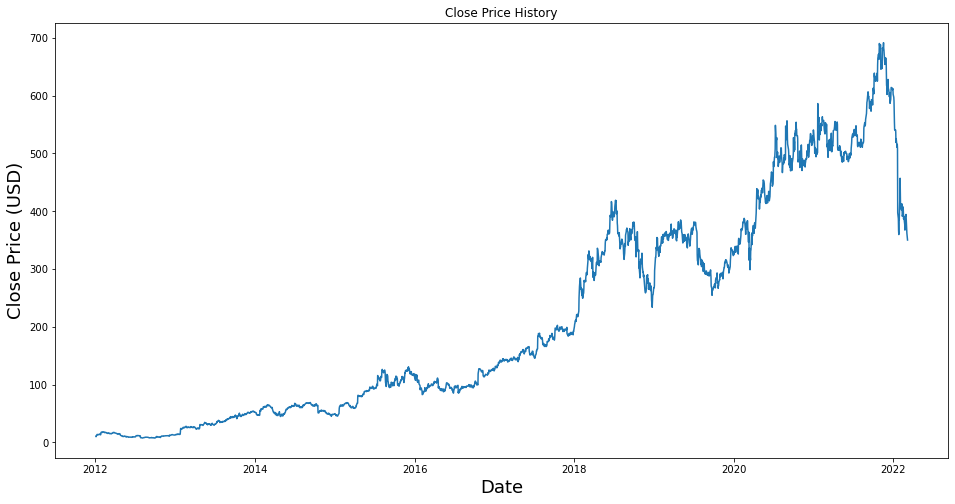

In [20]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00385127],
       [0.00556596],
       [0.00532578],
       ...,
       [0.52687432],
       [0.51760538],
       [0.50083647]])

In [22]:
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.00385127, 0.00556596, 0.00532578, 0.00678567, 0.00926895,
       0.00877814, 0.00800956, 0.00800956, 0.0084753 , 0.00854631,
       0.00934414, 0.0103717 , 0.00969919, 0.00838758, 0.00811816,
       0.00861315, 0.01299282, 0.0146177 , 0.01496022, 0.01386792,
       0.01444644, 0.01466156, 0.01516908, 0.01575805, 0.01547192,
       0.01466156, 0.014837  , 0.01464694, 0.01347109, 0.01446733,
       0.01425639, 0.01422506, 0.01421253, 0.01328313, 0.01223885,
       0.01236208, 0.01208639, 0.01161438, 0.012431  , 0.01189007,
       0.01231195, 0.01280276, 0.01190678, 0.01113819, 0.01073302,
       0.01133452, 0.0115559 , 0.01094396, 0.01097529, 0.01074555,
       0.01177311, 0.01172925, 0.01264194, 0.01278605, 0.01384703,
       0.0135609 , 0.01386583, 0.01424177, 0.01396608, 0.01357761])]
[0.012792318847363655]



In [23]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [24]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(2015, 60, 1)

In [25]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [26]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [27]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2015/2015 [==============================] - 36s 17ms/step - loss: 9.3957e-04


In [28]:
test_data = scaled_data[training_data_len-60: , :]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [29]:
x_test = np.array(x_test)

In [30]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [31]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [32]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

6.314408416120113

C:\Users\kapoo\AppData\Local\Temp/ipykernel_3504/2133332622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


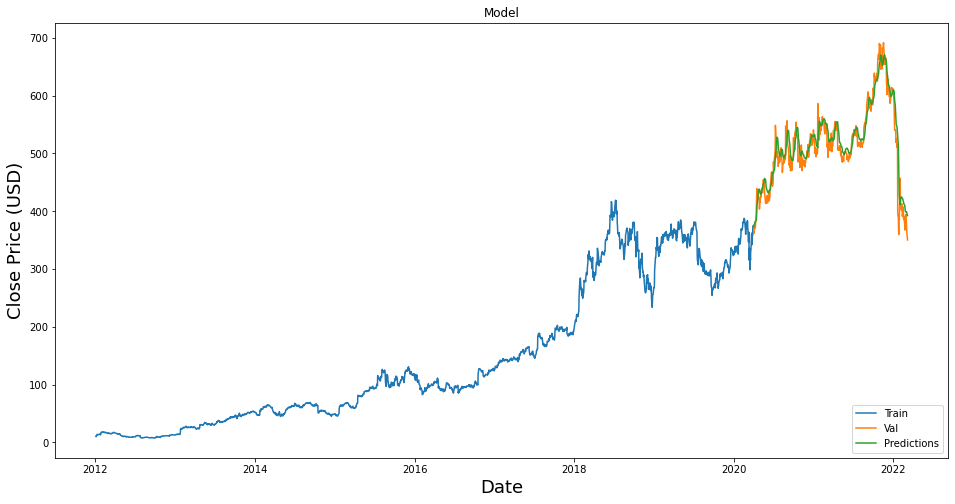

In [33]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc ='lower right')
plt.show()

In [34]:
valid

,Close,Predictions
Date,,
2020-04-02,370.079987,373.253326
2020-04-03,361.760010,376.262421
2020-04-06,379.959991,377.626495
2020-04-07,372.279999,380.068176
2020-04-08,371.119995,381.812775
...,...,...
2022-03-01,386.239990,399.222229
2022-03-02,380.029999,399.334198
2022-03-03,368.070007,398.642487


In [35]:
nflx_quote = web.DataReader('NFLX', data_source='yahoo',start='2012-01-01', end='2022-03-07')
new_df = nflx_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[387.40097]]


In [36]:
nflx_quote2 = web.DataReader('NFLX', data_source='yahoo',start='2022-03-01', end='2022-03-07')
print(nflx_quote2['Close'])

Date
2022-02-28    394.519989
2022-03-01    386.239990
2022-03-02    380.029999
2022-03-03    368.070007
2022-03-04    361.730011
2022-03-07    350.260010
Name: Close, dtype: float64
